<a href="https://colab.research.google.com/github/Jesse-Allister-Kasien-Elliott/Simplex-Algorithm-/blob/master/simplex_algorithm_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Simplex Algorithm Implementation in Python (for Google Colab)
# --------------------------------------------------------------
# This script implements the primal Simplex algorithm for solving
# linear programs in standard form:
#     maximize c^T x
#     subject to A x = b,  x >= 0
#
# It operates directly on the coefficient matrix A, constraint vector b,
# and objective vector c, using an explicit basis representation.
# The pivot rule here is simple: choose the first variable with a positive reduced cost.

import numpy as np

def simplex(c, A, b, BAS):
    """
    Solve a linear program in standard form using the Simplex algorithm.

    Parameters
    ----------
    c : (n,) array_like
        Objective coefficients.
    A : (m, n) array_like
        Constraint matrix.
    b : (m, 1) array_like
        Right-hand side vector.
    BAS : list of int
        Indices of the initial basic variables (0-based).

    Returns
    -------
    status : int
        0 if optimal, 1 if unbounded.
    x : (n, 1) ndarray
        Optimal solution vector (if found).
    """
    m, n = A.shape

    # Identify the set of non-basic variable indices
    N = [i for i in range(n) if i not in BAS]

    # Partition the objective coefficients into basic (cB) and non-basic (cN) parts
    cB = np.array([c[i] for i in BAS]).reshape(-1, 1)
    cN = np.array([c[i] for i in N]).reshape(-1, 1)

    # Partition the constraint matrix into basic (AB) and non-basic (AN) columns
    AB = A[:, BAS]
    AN = A[:, N]

    # Compute the basic feasible solution: xB = AB^{-1} b, xN = 0
    ABinv = np.linalg.inv(AB)
    xB = ABinv @ b
    xN = np.zeros((n - m, 1))

    # Compute reduced costs: cN^T - cB^T AB^{-1} AN
    cBarT = cN.T - (cB.T @ ABinv @ AN)

    # Main Simplex loop: iterate until all reduced costs are <= 0 (optimality)
    while np.any(cBarT > 0):
        # --- Entering variable selection (pivot column) ---
        entering_indices = np.where(cBarT > 0)[1]
        k = entering_indices[0]       # index in N of entering variable
        j = N[k]                       # actual variable index in [0, n)

        # Compute the direction vector for basic variables: dB = -AB^{-1} a_j
        dB = -ABinv @ A[:, j]

        # If all entries in dB are >= 0, the LP is unbounded
        if np.all(dB >= 0):
            print("UNBOUNDED")
            return 1, dB

        # --- Leaving variable selection (pivot row) ---
        theta_vec = -xB.flatten() / dB.flatten()  # ratios
        valid_indices = np.where(dB < 0)[0]       # only consider negative directions
        theta_vec = theta_vec[valid_indices]
        l_index = valid_indices[np.argmin(theta_vec)]  # smallest ratio rule
        l = BAS[l_index]  # actual leaving variable index

        # --- Pivot: update basis sets ---
        BAS[l_index] = j   # new basic variable
        N[k] = l           # new non-basic variable
        BAS.sort()
        N.sort()

        # --- Update all quantities after pivot ---
        cB = np.array([c[i] for i in BAS]).reshape(-1, 1)
        cN = np.array([c[i] for i in N]).reshape(-1, 1)
        AB = A[:, BAS]
        AN = A[:, N]
        ABinv = np.linalg.inv(AB)
        xB = ABinv @ b
        xN = np.zeros((n - m, 1))
        cBarT = cN.T - (cB.T @ ABinv @ AN)

    # Construct the full solution vector x from xB and xN
    x = np.zeros((n, 1))
    for i, idx in enumerate(BAS):
        x[idx] = xB[i]
    for idx in N:
        x[idx] = 0

    return 0, x  # status=0 means optimal

# --------------------------------------------------------------
# Example usage — small bounded LP
# Maximize   z = x1 + 4 x2
# Subject to x1 + 2x2 <= 2
#            x1 +  x2 <= 4
# and x >= 0
# --------------------------------------------------------------

c = np.array([1, 4, 0, 0])  # objective coefficients (including slacks)
A = np.array([[1, 2, 1, 0],
              [1, 1, 0, 1]])
b = np.array([[2], [4]])
BAS = [0, 3]  # initial basic variable indices (0-based)

status, solution = simplex(c, A, b, BAS)

print("Status:", "Optimal" if status == 0 else "Unbounded")
print("Solution:")
print(solution)


Status: Optimal
Solution:
[[0.]
 [1.]
 [0.]
 [3.]]


In [ ]:
# -------------------------------------------------------------
# Script 2 — Generate supervised data with non-trivial pivot paths
#   - Bigger LPs by default (m=10, n=20)
#   - Reject trivial runs (< MIN_STEPS pivots); resample
#   - Outputs the same file/format: pivot_data_big.npz with X, y
# -------------------------------------------------------------

import numpy as np

# ---- CONFIG ----
M, N = 10, 20           # constraints, decision vars
NUM_INSTANCES = 2000    # accepted LPs (after filtering)
MIN_STEPS = 5           # require at least this many pivots
MAX_STEPS = 400         # safety cap per LP
SEED = 42               # reproducibility
# -----------------

rng = np.random.default_rng(SEED)

# ---------------------------
# Tableau + pivot utils
# ---------------------------
def build_tableau(A, b, c):
    """Ax <= b, x >= 0, maximize c^T x; add slacks and build tableau."""
    m, n = A.shape
    T = np.zeros((m + 1, n + m + 1), dtype=float)
    T[:m, :n] = A
    T[:m, n:n+m] = np.eye(m)
    T[:m, -1] = b
    T[-1, :n] = -c
    return T

def dantzig_entering(T):
    rc = T[-1, :-1]
    j = np.argmax(rc)
    return None if rc[j] <= 1e-12 else int(j)

def leaving_row(T, j):
    m = T.shape[0] - 1
    col = T[:m, j]
    rhs = T[:m, -1]
    pos = col > 1e-12
    if not np.any(pos):  # unbounded
        return None
    return int(np.argmin(np.where(pos, rhs / col, np.inf)))

def pivot(T, i, j):
    piv = T[i, j]
    T[i, :] /= piv
    for r in range(T.shape[0]):
        if r != i:
            T[r, :] -= T[r, j] * T[i, :]

# ---------------------------
# LP generator (same dist, but bigger by default)
# ---------------------------
def sample_lp(m=M, n=N):
    # Slightly perturbed Gaussian; positive b improves feasibility with slacks
    A = rng.normal(0, 1, size=(m, n)) + rng.normal(0, 0.1, size=(m, n))
    b = np.abs(rng.normal(0, 2, size=m)) + 0.5
    # Make objective “harder”: correlated components + noise
    base = rng.normal(0, 1, size=n)
    c = 0.7 * base + 0.3 * rng.normal(0, 1, size=n)
    return A, b, c

# ---------------------------
# Run simplex and collect features/labels
# ---------------------------
def run_and_collect(A, b, c, max_steps=MAX_STEPS):
    """
    Returns (X_step_list, y_step_list, steps, status)
      status: 'ok' | 'unbounded' | 'optimal0'
    """
    T = build_tableau(A, b, c)
    Xs, ys = [], []
    steps = 0
    for _ in range(max_steps):
        rc = T[-1, :-1].copy()       # features
        j = dantzig_entering(T)      # label
        if j is None:
            return Xs, ys, steps, ('optimal0' if steps == 0 else 'ok')
        i = leaving_row(T, j)
        if i is None:
            return Xs, ys, steps, 'unbounded'
        Xs.append(rc); ys.append(j)
        pivot(T, i, j)
        steps += 1
    return Xs, ys, steps, 'ok'

# ---------------------------
# Dataset generation with filtering
# ---------------------------
def generate_dataset(num_instances=NUM_INSTANCES, m=M, n=N, min_steps=MIN_STEPS):
    X_list, y_list = [], []
    accepted = 0
    attempts = 0
    unbounded = 0
    trivial = 0

    while accepted < num_instances:
        attempts += 1
        A, b, c = sample_lp(m, n)
        Xs, ys, steps, status = run_and_collect(A, b, c)
        if status == 'unbounded':
            unbounded += 1
            continue
        if steps < min_steps:
            trivial += 1
            continue
        X_list.extend(Xs)
        y_list.extend(ys)
        accepted += 1
        if accepted % 100 == 0:
            print(f"accepted {accepted}/{num_instances} (attempts={attempts}, trivial={trivial}, unbounded={unbounded})")

    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.int64)
    print(f"Done. Accepted LPs: {accepted}, attempts: {attempts}, "
          f"trivial(<{min_steps}): {trivial}, unbounded: {unbounded}, "
          f"total_pivots: {len(y)} (avg per LP ≈ {len(y)/accepted:.2f})")
    return X, y

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    X, y = generate_dataset()
    np.savez_compressed("pivot_data_big.npz", X=X, y=y)
    print(f"Saved pivot_data_big.npz with X.shape={X.shape}, y.shape={y.shape}")


accepted 100/2000 (attempts=2221, trivial=2, unbounded=2119)
accepted 200/2000 (attempts=4329, trivial=6, unbounded=4123)
accepted 300/2000 (attempts=6412, trivial=8, unbounded=6104)
accepted 400/2000 (attempts=8551, trivial=10, unbounded=8141)
accepted 500/2000 (attempts=10568, trivial=15, unbounded=10053)
accepted 600/2000 (attempts=12677, trivial=19, unbounded=12058)
accepted 700/2000 (attempts=14795, trivial=22, unbounded=14073)
accepted 800/2000 (attempts=16795, trivial=28, unbounded=15967)
accepted 900/2000 (attempts=18848, trivial=29, unbounded=17919)
accepted 1000/2000 (attempts=20838, trivial=32, unbounded=19806)
accepted 1100/2000 (attempts=22950, trivial=38, unbounded=21812)
accepted 1200/2000 (attempts=25189, trivial=43, unbounded=23946)
accepted 1300/2000 (attempts=27429, trivial=44, unbounded=26085)
accepted 1400/2000 (attempts=29790, trivial=50, unbounded=28340)
accepted 1500/2000 (attempts=32412, trivial=54, unbounded=30858)
accepted 1600/2000 (attempts=34408, trivial=5

In [ ]:
# -------------------------------------------------------------
# Script 3 — Train a Neural Network to Imitate Dantzig's Pivot Rule
#
# Loads: pivot_data_big.npz (features X, labels y) from Script 2
# Saves: pivot_model.pt (trained NN weights) and norm_stats.npz (feature normalization)
#
# The model is a simple feed-forward MLP classifier:
#   Input:  reduced cost vector before each pivot
#   Output: probability distribution over possible entering variables
#   Loss:   cross-entropy with Dantzig's chosen entering variable as the label
#
# This script is the "machine learning" part of the pipeline.
# -------------------------------------------------------------

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------------------------------------------
# Model definition — simple 2-hidden-layer feed-forward MLP
# -------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, d_in, d_out):
        """
        Parameters
        ----------
        d_in : int
            Input dimension (number of features = n + m).
        d_out : int
            Output dimension (number of possible entering variables).
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, d_out)
        )
    def forward(self, x):
        return self.net(x)

# -------------------------------------------------------------
# Load dataset from disk
# X: reduced costs before each pivot (float32)
# y: index of the entering variable chosen by Dantzig (int64)
# -------------------------------------------------------------
def load_data(path="pivot_data_big.npz"):
    data = np.load(path)
    X = data["X"].astype(np.float32)
    y = data["y"].astype(np.int64)
    return X, y

# -------------------------------------------------------------
# Normalize features to zero mean, unit variance
# Saves mean and std for use at inference time
# -------------------------------------------------------------
def normalize(X):
    """
    Returns normalized X, along with mean and std for later inference.
    """
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True) + 1e-8
    Xn = (X - mean) / std
    return Xn, mean.squeeze(0), std.squeeze(0)

# -------------------------------------------------------------
# Training loop
# ---------------------------------------------------------


In [ ]:
##### here I am looking at the data .. basic sanity tests

print(data.files)

print("X shape:", data['X'].shape)
print("y shape:", data['y'].shape)

print("First 5 X examples:\n", data['X'][:5])
print("First 5 y labels:\n", data['y'][:5])

['X', 'y']


In [ ]:
x_test = torch.ones((1, X.shape[1]), dtype=torch.float32)  # input shape matches training
logits = model(x_test)
predicted_index = torch.argmax(logits, dim=1).item()
print("Predicted pivot index:", predicted_index)


Predicted pivot index: 0


In [ ]:
# Pivot rule: choose the index of the most negative reduced cost
# (i.e., argmin). If all entries are non-negative, no pivot is chosen.

x_test = torch.empty((1, X.shape[1])).uniform_(-5, 5)  # random reduced cost vector
logits = model(x_test)
predicted_index = torch.argmax(logits, dim=1).item()
print("Input:", x_test.numpy().flatten())
print("Predicted pivot index:", predicted_index)


Input: [-0.5545491  1.0126728 -3.1042213  3.3761148  2.850954  -2.8627353
 -2.5979762  2.646317   1.3461691 -4.977786 ]
Predicted pivot index: 1



===== Descriptive stats =====
Dantzig  avg pivots: 6.34 ± 0.17 (n=1000, min=1.0, max=22.0)
NN       avg pivots: 6.99 ± 0.20 (n=1000, min=1.0, max=22.0)
NN − Dantzig diff :  +0.66 ± 0.16 (min=-8, max=+15)
W/L/T counts      :  282/473/245


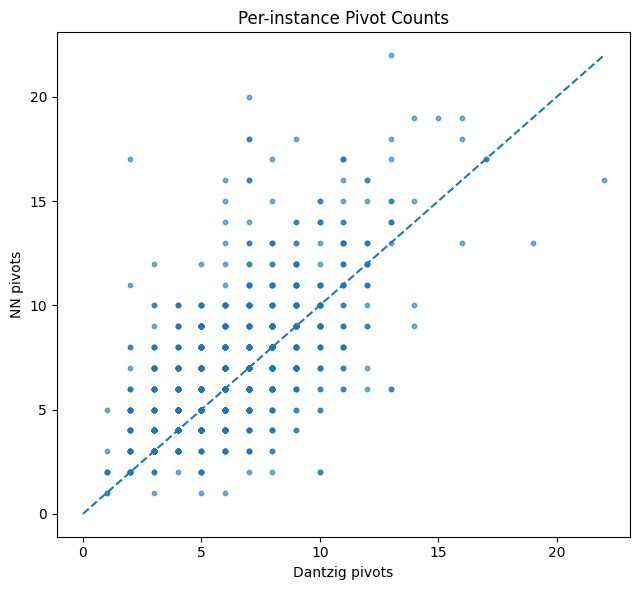

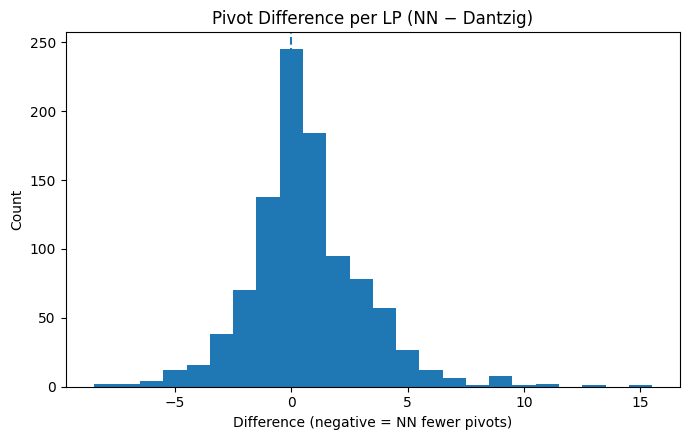

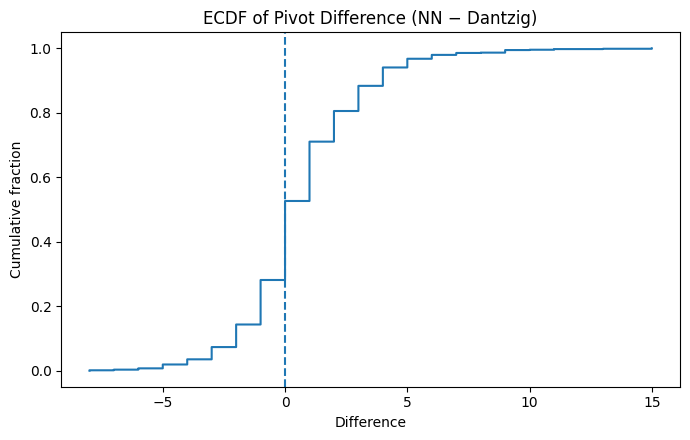

Saved: scatter_pivots.png, histogram_diff.png, ecdf_diff.png


In [ ]:
# -------------------------------------------------------------
# Script 5 — Visualize NN vs Dantzig (force recompute, better plots)
# -------------------------------------------------------------
import os, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim

# ---- CONFIG (match Script 4) ----
M, N = 10, 20
TEST_LPS = 1000
SEED = 123
RESULTS_PATH = f"results_m{M}_n{N}.npz"
FORCE_RECOMPUTE = True   # <- set True to avoid stale cached results
# ---------------------------------

rng = np.random.default_rng(SEED)

# ---------- Simplex helpers ----------
def build_tableau(A,b,c):
    m,n = A.shape
    T = np.zeros((m+1, n+m+1), float)
    T[:m,:n] = A; T[:m,n:n+m] = np.eye(m); T[:m,-1] = b; T[-1,:n] = -c
    return T
def dantzig_entering(T):
    rc = T[-1,:-1]; j = np.argmax(rc); return j if rc[j] > 1e-12 else None
def leaving_row(T,j):
    m = T.shape[0]-1; col = T[:m,j]; rhs = T[:m,-1]; pos = col > 1e-12
    if not np.any(pos): return None
    return int(np.argmin(np.where(pos, rhs/col, np.inf)))
def pivot(T,i,j):
    p = T[i,j]; T[i,:] /= p
    for r in range(T.shape[0]):
        if r != i: T[r,:] -= T[r,j]*T[i,:]
def sample_lp(m=M,n=N):
    A = rng.normal(0,1,(m,n)) + rng.normal(0,0.1,(m,n))
    b = np.abs(rng.normal(0,2,m)) + 0.5
    c = rng.normal(0,1,n)
    return A,b,c
def run_simplex(A,b,c,selector,max_steps=20000):
    T = build_tableau(A,b,c); steps = 0
    for _ in range(max_steps):
        j = selector(T)
        if j is None: break
        i = leaving_row(T,j)
        if i is None: break
        pivot(T,i,j); steps += 1
    return steps

# ---------- Load real NN (same arch as Script 4) ----------
class MLP(nn.Module):
    def __init__(self,d_in,d_out):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_in,64), nn.ReLU(),
                                 nn.Linear(64,64), nn.ReLU(),
                                 nn.Linear(64,d_out))
    def forward(self,x): return self.net(x)

def load_model_for_size(m=M,n=N):
    model_path = f"pivot_model_m{m}_n{n}.pt"
    stats_path = f"norm_stats_m{m}_n{n}.npz"
    if not (os.path.exists(model_path) and os.path.exists(stats_path)):
        raise FileNotFoundError(
            f"Missing model/stats for (m={m}, n={n}). "
            f"Run Script 4 once to train: it will create {model_path} and {stats_path}."
        )
    stats = np.load(stats_path)
    mean = stats["mean"].astype(np.float32); std = stats["std"].astype(np.float32)
    d = mean.shape[0]; model = MLP(d,d)
    model.load_state_dict(torch.load(model_path, map_location="cpu")); model.eval()
    return model, mean, std

def nn_selector_factory(model, mean, std):
    def selector(T):
        rc = T[-1,:-1].astype(np.float32); mask = rc > 1e-12
        if not mask.any(): return None
        x = (rc - mean)/(std + 1e-8)
        with torch.no_grad():
            logits = model(torch.from_numpy(x)[None,:]).squeeze(0).cpu().numpy()
        j = int(np.where(mask, logits, -1e30).argmax())
        return j if rc[j] > 1e-12 else dantzig_entering(T)
    return selector

# ---------- Get results (force recompute uses the NN) ----------
def get_results():
    if os.path.exists(RESULTS_PATH) and not FORCE_RECOMPUTE:
        d = np.load(RESULTS_PATH)
        return d["steps_d"].astype(float), d["steps_nn"].astype(float)

    model, mean, std = load_model_for_size(M, N)
    nn_sel = nn_selector_factory(model, mean, std)

    steps_d, steps_nn = [], []
    for _ in range(TEST_LPS):
        A,b,c = sample_lp(M,N)
        steps_d.append(run_simplex(A,b,c, dantzig_entering))
        steps_nn.append(run_simplex(A,b,c, nn_sel))
    steps_d = np.array(steps_d, float); steps_nn = np.array(steps_nn, float)
    np.savez_compressed(RESULTS_PATH, steps_d=steps_d, steps_nn=steps_nn)
    return steps_d, steps_nn

steps_d, steps_nn = get_results()
diff = steps_nn - steps_d

# ---------- Descriptive stats ----------
def ci95(a):
    a = np.asarray(a, float)
    return a.mean(), 1.96*a.std(ddof=1)/np.sqrt(len(a)), a.min(), a.max()
md, cd, mind, maxd = ci95(steps_d)
mn, cn, minn, maxn = ci95(steps_nn)
mean_diff, ci_diff, mindf, maxdf = ci95(diff)
wins = int((diff < 0).sum()); ties = int((diff == 0).sum())
losses = len(diff) - wins - ties

print("\n===== Descriptive stats =====")
print(f"Dantzig  avg pivots: {md:.2f} ± {cd:.2f} (n={len(diff)}, min={mind}, max={maxd})")
print(f"NN       avg pivots: {mn:.2f} ± {cn:.2f} (n={len(diff)}, min={minn}, max={maxn})")
print(f"NN − Dantzig diff :  {mean_diff:+.2f} ± {ci_diff:.2f} (min={mindf:+.0f}, max={maxdf:+.0f})")
print(f"W/L/T counts      :  {wins}/{losses}/{ties}")

# ---------- Plot A: Scatter NN vs D with y=x ----------
plt.figure(figsize=(6.5, 6))
plt.scatter(steps_d, steps_nn, s=10, alpha=0.6)
mx = max(steps_d.max(), steps_nn.max())
plt.plot([0, mx],[0, mx], linestyle="--")  # y=x
plt.xlabel("Dantzig pivots"); plt.ylabel("NN pivots")
plt.title("Per-instance Pivot Counts")
plt.tight_layout(); plt.savefig("scatter_pivots.png", dpi=160); plt.show()

# ---------- Plot B: Histogram of integer differences ----------
plt.figure(figsize=(7, 4.5))
bins = np.arange(diff.min()-0.5, diff.max()+1.5, 1.0)  # integer bins
plt.hist(diff, bins=bins)
plt.axvline(0, linestyle="--")
plt.title("Pivot Difference per LP (NN − Dantzig)")
plt.xlabel("Difference (negative = NN fewer pivots)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("histogram_diff.png", dpi=160); plt.show()

# ---------- Plot C: ECDF of differences (smooth read of closeness) ----------
x = np.sort(diff); y = np.arange(1, len(x)+1)/len(x)
plt.figure(figsize=(7, 4.5))
plt.step(x, y, where="post")
plt.axvline(0, linestyle="--")
plt.title("ECDF of Pivot Difference (NN − Dantzig)")
plt.xlabel("Difference"); plt.ylabel("Cumulative fraction")
plt.tight_layout(); plt.savefig("ecdf_diff.png", dpi=160); plt.show()

print("Saved: scatter_pivots.png, histogram_diff.png, ecdf_diff.png")



===== Descriptive stats =====
Dantzig  avg pivots: 6.34 ± 0.17 (n=1000, min=1.0, max=22.0)
NN       avg pivots: 6.34 ± 0.17 (n=1000, min=1.0, max=22.0)
NN − Dantzig diff :  +0.00 ± 0.00 (min=+0, max=+0)
W/L/T counts      :  0/0/1000
Saved: histogram_diff.png and boxplot_pivots.png


/tmp/ipython-input-3713847165.py:155: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([steps_d, steps_nn], labels=["Dantzig", "NN"], showmeans=True)
